# Doc2Vec (Figures 3, 4 and Tables 3, 4)

adapted (partially) from https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb

In [1]:
import json
import re
from collections import namedtuple

import gensim

train = False

Document = namedtuple('Document', 'words tags')

alldocs = []  # will hold all docs in original order
with open('../data/c_twitter.json') as f_in:
    for line in f_in:
        c_twt = json.loads(line)
        # c_twt: {'weeknum': str, 'c_text': str, 'tags': [str]}
        words = c_twt['text'].split()
        tags = [str(c_twt['id'])] + c_twt['tags']
        alldocs.append(Document(words, tags))
        
shuffle_docs = alldocs[:]

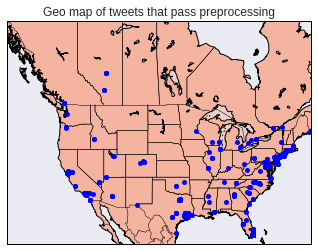

number of geo-tweets: 6136


In [2]:
import sys
if not('/high_spd_work/sm_w2v' in sys.path):
    sys.path.append('/high_spd_work/sm_w2v')
    
from sm_w2v.plot_utils import plot_map_twts
%matplotlib inline

def twt_gen():
    with open('../data/c_twitter.json') as f_in:
        for line in f_in:
            c_twt = json.loads(line)
            if 'coordinates' in c_twt:
                yield c_twt
            
geo_twts = list(twt_gen())
plot_map_twts(geo_twts, 'Geo map of tweets that pass preprocessing')
print('number of geo-tweets:', len(geo_twts))

# Build model and train (or load model from file)

In [6]:
import multiprocessing
from random import shuffle
import random
import time

from gensim.models import Doc2Vec
import gensim.models.doc2vec

import numpy as np

random.seed(1)
np.random.seed(1)



if train:
    cores = multiprocessing.cpu_count()
    assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

    # PV-DM w/average
    model= Doc2Vec(dm=1, dm_mean=1, size=100, window=3, negative=5, hs=0, min_count=2, workers=cores,
               max_vocab_size=10000, seed=1)


    # the array is too big
    model.build_vocab(alldocs)
    print("model:", model)

    # train model
    passes = 10
    start_time = time.time()

    for epoch in range(passes):
        shuffle(shuffle_docs)
        model.train(shuffle_docs)
        print(epoch, model.most_similar('hiv', topn=10))

        # do some validation after each epoch
        doc_ids = random.sample(range(len(alldocs)), 1000)
        score = 0
        for doc_id in doc_ids:
            inferred_docvec = model.infer_vector(alldocs[doc_id].words)
            score += sum(abs(model.docvecs[doc_id] - inferred_docvec))
        print("--- score: ", score)
        print("ELAPSED TIME (seconds): ", time.time() - start_time)

    model.save('../models/doc2vec.model')
else:
    model = Doc2Vec.load('../models/doc2vec.model')

# Table 4: Related Word-Vectors

In [9]:
import pandas as pd
new_vecs = model.most_similar(['hivaids'], topn=10)
df_hivaids = pd.DataFrame(data=new_vecs, columns=['Related-Word', 'Cosine Similarity to \"hivaids\"'])
df_hivaids

,Related-Word,"Cosine Similarity to ""hivaids"""
0,hiv,0.912922
1,aidshiv,0.830171
2,hiv-aids,0.820133
3,communityhealthworkers,0.778889
4,hivtestweek,0.775639
5,rethinkhiv,0.760806
6,hiv',0.759864
7,hiv-1,0.744041
8,worldaidsday,0.734604
9,stophivstigma,0.733197


In [10]:
new_vecs = model.most_similar(['prep'], topn=10)
df_prep = pd.DataFrame(data=new_vecs, columns=['Related Word', 'Cosine Similarity to \"prep\"'])
df_prep

,Related Word,"Cosine Similarity to ""prep"""
0,benegative,0.812816
1,truvada,0.802233
2,hivtestweek,0.753280
3,gettested,0.749612
4,icasa2015,0.744382
5,charliesheen,0.740174
6,doingit,0.734164
7,zika,0.705530
8,iknowkati,0.705024
9,worldaidsday,0.704126


In [11]:
new_vecs = model.most_similar(['prophylaxis'], topn=10)
df_prophylaxis = pd.DataFrame(data=new_vecs, columns=['Related Word', 'Cosine Similarity to \"prophylaxis\"'])
df_prophylaxis

,Related Word,"Cosine Similarity to ""prophylaxis"""
0,prophylaxisprep,0.564069
1,africa,0.473977
2,nutrition,0.439196
3,hiv-infected,0.420552
4,considered,0.420470
5,lying,0.414741
6,hiv-related,0.414140
7,plannedparenthood,0.412505
8,develop,0.410069
9,vaccination,0.408779


In [12]:
new_vecs = model.most_similar(['truvada'], topn=10)
df_truvada = pd.DataFrame(data=new_vecs, columns=['Related Word', 'Cosine Similarity to \"truvada\"'])
df_truvada

,Related Word,"Cosine Similarity to ""truvada"""
0,prep,0.802233
1,hivtestweek,0.754421
2,worldaidsday,0.740197
3,charliesheen,0.734512
4,icasa2015,0.725005
5,benegative,0.715968
6,givingtuesday,0.713566
7,hiv,0.711799
8,communityhealthworkers,0.706927
9,hivaids,0.706700


# Figure 3: PCA and tSNE plots of relevent word vectors

PCA explained variance ratio:  [ 0.07475097  0.05757501]


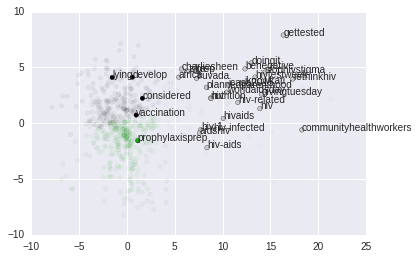

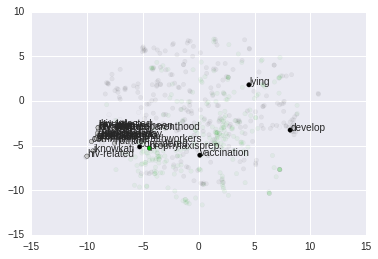

In [15]:
import sys

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# append path to my module
if '/high_spd_work/sm_w2v' not in sys.path:
    sys.path.append('/high_spd_work/sm_w2v')
from sm_w2v.plot_utils import scatter_plot

# related words from above
related_words = list(df_hivaids.iloc[:,0].values) + \
                list(df_prep.iloc[:,0].values) + \
                list(df_prophylaxis.iloc[:,0].values) + \
                list(df_truvada.iloc[:,0].values)

# Prepare data matrix
X = []
text_annotations = []
for word in model.vocab:
    X.append(model[word])
    if word in related_words:
        text_annotations.append(word)
    else:
        text_annotations.append("")
X = np.array(X)

# Do k-means on original data matrix
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans_labels = kmeans.fit_predict(X)

# Do PCA
pca = PCA(n_components=2, copy=True)
pca.fit(X)
print("PCA explained variance ratio: ", pca.explained_variance_ratio_)
pca_comps = pca.transform(X)

# Do tSNE
tsne = TSNE(n_components=2, random_state=1)
tsne_comps = tsne.fit_transform(X)

# Scatter plot
rand_seed = 0
alpha_high = 1.0
alpha_low = 0.05
down_samp_rate = 0.1

# save PCA plot in 'notebooks' directory
scatter_plot(pca_comps[:,0], pca_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "Fig3a: PCA of Related Words", rand_seed, None)

# save tSNE plot in 'notebooks' directory
scatter_plot(tsne_comps[:,0], tsne_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "Fig3b: tSNE of Related Words", rand_seed, None)

# Table 4: Related Hashtags and Tweets

Hashtags begin with "#", users begin with "user--" and tweets are just a number - that refers to the corresponding index in the "alldocs" variable, or the "../data/c_twitter.json" cleaned tweets file

In [16]:
new_vecs = model.docvecs.most_similar(['#truvada'], topn=10)
df_hash_truvada = pd.DataFrame(data=new_vecs, columns=['Related Hashtag/User/Tweet', 'Cosine Similarity to \"#truvada\"'])
df_hash_truvada

,Related Hashtag/User/Tweet,"Cosine Similarity to ""#truvada"""
0,#prep,0.745294
1,#hiv,0.719835
2,685137143468011520,0.632690
3,676893440798531584,0.627940
4,678636092933857280,0.627616
5,#worldsaidsday,0.624474
6,684666507029262336,0.617330
7,#bethegeneration,0.616657
8,#prevention,0.613976
9,#bbbh,0.610722


In [17]:
new_vecs = model.docvecs.most_similar(['#sexwork'], topn=10)
df_hash_sexwork = pd.DataFrame(data=new_vecs, columns=['Related Hashtag/User/Tweet', 'Cosine Similarity to \"#sexwork\"'])
df_hash_sexwork

,Related Hashtag/User/Tweet,"Cosine Similarity to ""#sexwork"""
0,686964391678455809,0.639374
1,685137143468011520,0.627542
2,688748800022851588,0.624880
3,685125817001734145,0.622713
4,#hiv,0.621191
5,686123783757893633,0.620029
6,687395919088726017,0.614378
7,674411095793119232,0.614133
8,686108596950675457,0.614083
9,#hiphoped,0.610855


In [18]:
new_vecs = model.docvecs.most_similar(['#prep'], topn=10)
df_hash_prep = pd.DataFrame(data=new_vecs, columns=['Related Related Hashtag/User/Tweet', 'Cosine Similarity to \"#prep\"'])
df_hash_prep

,Related Related Hashtag/User/Tweet,"Cosine Similarity to ""#prep"""
0,#truvada,0.745294
1,#hiv,0.692177
2,#prevention,0.617699
3,#hivprep,0.615363
4,#prepworks,0.602093
5,#gay,0.586058
6,688737078998384645,0.584895
7,#askthehivdoc,0.577031
8,686137308127559680,0.565482
9,686964392743845889,0.565249


In [19]:
# note, this tweet is popular, warning about 13 signs which indicate that you need HIV testing.
# We see evidence of this populat tweet-retweet in both DTM and Doc2Vec:
#
# Document(words=['#', 'krtebireysyle', 'if', 'you', 'see', 'this', '13',
# 'symptoms', '.', 'do', 'hiv', 'test', 'immediately', '.', 'please', 'read'],
# tags=[603177, '#KFB_Mz_Sope', 'kürtçebirşeysöyle'])
#
alldocs[603177]

Document(words=['u', 'gone', 'get', 'aids', 'n', 'stds', 'n', 'yo', 'ass'], tags=['699316802468343811', 'King_-*-2838337994'])

In [20]:
new_vecs = model.docvecs.most_similar(['#imtesting'], topn=10)
df_hash_imtesting = pd.DataFrame(data=new_vecs, columns=['Related Related Hashtag/User/Tweet', 'Cosine Similarity to \"#imtesting\"'])
df_hash_imtesting

,Related Related Hashtag/User/Tweet,"Cosine Similarity to ""#imtesting"""
0,#hivtestweek,0.630049
1,#wadirl,0.530862
2,#nhtw,0.478717
3,#dotmed16,0.463532
4,Herts Aid-*-360529743,0.462127
5,Dr Jane Dickson-*-1016205812,0.459735
6,H.O.P.E.-*-97489261,0.458919
7,670986786928218112,0.455013
8,yorkshire mesmac-*-74150233,0.453386
9,#hivtestingweek,0.448027


# Figure 4: Related Hashtags and Tweets

In [21]:
# related words from above
related_words = list(df_hash_truvada.iloc[:,0].values) + \
                list(df_hash_sexwork.iloc[:,0].values) + \
                list(df_hash_prep.iloc[:,0].values) + \
                list(df_hash_imtesting.iloc[:,0].values)

# Prepare data matrix
X = []
text_annotations = []
for i, word in enumerate(model.docvecs.doctags):
    if (i % 100 == 0 or word in related_words) :
        X.append(model.docvecs[word])
        if word in related_words:
            text_annotations.append(word)
        else:
            text_annotations.append("")
X = np.array(X)

# Do k-means on original data matrix
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans_labels = kmeans.fit_predict(X)

# Do PCA
pca = PCA(n_components=2, copy=True)
pca.fit(X)
print("PCA explained variance ratio: ", pca.explained_variance_ratio_)
pca_comps = pca.transform(X)

# Do tSNE
tsne = TSNE(n_components=2, random_state=1)
tsne_comps = tsne.fit_transform(X)

# Scatter plot
rand_seed = 0
alpha_high = 1.0
alpha_low = 0.05
down_samp_rate = 0.1

# save PCA plot in 'notebooks' directory (it won't show here in the notebook)
scatter_plot(pca_comps[:,0], pca_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "Fig4a: PCA of Related Hashtags-Users-Tweets", rand_seed, None)

# save tSNE plot in 'notebooks' directory (it won't show here in the notebook)
scatter_plot(tsne_comps[:,0], tsne_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "Fig4b: tSNE of Hashtags-Users-Tweets", rand_seed, None)

PCA explained variance ratio:  [ 0.0671753   0.03751989]


KeyboardInterrupt: 

# get ~24,000 users related to PrEP sorted

and store in '../data/top_users_to_PrEP.txt'


this is providing data for other notebook:

`topic_modeling_on_user-timelines.ipynb`

and was only run once:



In [28]:
# # get top 1000 user id strings and save for user-timeline analysis
# sim_vecs = model.docvecs.most_similar(['#prep'], topn=100000)
# users = []
# for v in sim_vecs:
#     l = v[0].split('-*-')
#     if len(l) > 1:
#         users.append(l[-1])

# with open('../data/top_users_to_PrEP.txt', 'w') as f_out:
#     f_out.write('\n'.join(users))
